In [4]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers, initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import PIL 
import re
from PIL import Image
import os

No. of images = 400
No. of image masks = 400
No. of image labels = 400


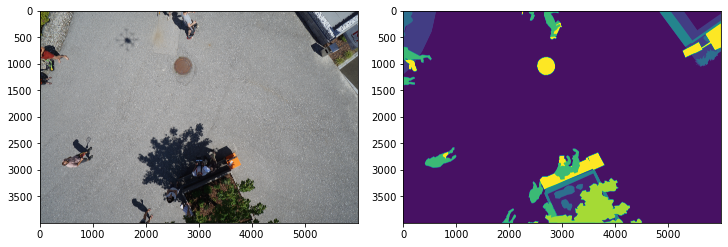

In [3]:
data_path1 = "C:/Users/kzhan/Desktop/Aerial Drone Seg/dataset/semantic_drone_dataset"

semantic_images = os.path.join(data_path1 + "/label_images_semantic")
original_images = os.path.join(data_path1 + "/original_images")
label_images = os.path.join("C:/Users/kzhan/Desktop/Aerial Drone Seg/RGB_color_image_masks/RGB_color_image_masks")

sample_original = os.path.join(original_images + "/000.jpg")
sample_semantic = os.path.join(semantic_images + "/000.png")

fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
axs[0].imshow(Image.open(sample_original))
axs[1].imshow(Image.open(sample_semantic))

print("No. of images =",len(os.listdir(original_images)))
print("No. of image masks =",len(os.listdir(semantic_images)))
print("No. of image labels =", len(os.listdir(label_images)))

In [6]:
def sorted_alphanum(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key :[convert (c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key = alphanum_key)

def load_images_masks(path_images,path_masks):
    images = os.listdir(path_images)
    masks = os.listdir(path_masks)
    images_list = []
    masks_list = []
    print(len(images))

    images2 = sorted_alphanum(images)
    masks2 = sorted_alphanum(masks)
    
    for i in images2:
        im = Image.open(path_images + i)
        im1 = np.array(im.resize((128,128)))/255
        images_list.append(im1)
 
    for i in masks2:
        mask = Image.open(path_masks + i)
        mask1 = np.array(mask.resize((128,128)))/255
        masks_list.append(mask1)
        
    return images_list,masks_list

original_images = os.path.join(data_path1 + "/original_images/")
label_images = os.path.join("C:/Users/kzhan/Desktop/Aerial Drone Seg/RGB_color_image_masks/RGB_color_image_masks/")
X, y = load_images_masks(original_images, label_images)

print(len(os.listdir(original_images)),len(X),len(y))
print(X[0].shape, y[0].shape)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

400
400 400 400
(128, 128, 3) (128, 128, 3)
(400, 128, 128, 3) (400, 128, 128, 3)


In [7]:
import tensorflow as tf
from tensorflow import keras

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

image_size = 128
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32     
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

model1 = UNet()
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
#Define Fully-Connected Network Architecture

'''
Author: Kenneth Zhang
'''

image_size = 128

def FCN_model(len_classes = 2, dropout_rate = 0.2):
    
    input = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Fully connected layer 1
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=64)(x)
    # x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 2
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=len_classes)(x)
    # predictions = tf.keras.layers.Activation('softmax')(x)

    # Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.Model(inputs = input, outputs = predictions)
    
    print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model

model2 = FCN_model()
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 124, 64)      0   